# Text-to-Motion Retrieval

**Structure des données :**
```
data/
├── motions/          → N fichiers .npy  (train)
├── texts/            → N fichiers .txt  (3 descriptions par motion)
└── test/
    ├── 1/
    │   ├── *.npy     → 30 motions candidats
    │   └── text.txt  → 1 requête texte
    ├── 2/ ...
    └── 30/
```
**Logique de soumission :** pour chaque dossier N, lire `text.txt` et classer les 30 `.npy` du même dossier.

## 0. Installations & imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import random
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {device}')

/home/guill/Challenge Data/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device : cuda


---
## 1. Exploration

In [4]:
DATA_DIR   = Path('data/data')
MOTION_DIR = DATA_DIR / 'motions'
TEXT_DIR   = DATA_DIR / 'texts'
TEST_DIR   = DATA_DIR / 'test'

# ── Motions train ────────────────────────────────────────────────────────────
motion_files = sorted(MOTION_DIR.glob('*.npy'))
sample_m = np.load(motion_files[0])
print('=== MOTIONS TRAIN ===')
print(f'  Nombre          : {len(motion_files)}')
print(f'  Shape exemple   : {sample_m.shape}')
print(f'  Dtype           : {sample_m.dtype}')
print(f'  Noms (3 ex)     : {[f.name for f in motion_files[:3]]}')

# ── Textes train ─────────────────────────────────────────────────────────────
txt_files = sorted(TEXT_DIR.glob('*.txt'))
sample_txt = txt_files[0].read_text('utf-8').strip()
lines      = [l for l in sample_txt.splitlines() if l.strip()]
print('\n=== TEXTES TRAIN ===')
print(f'  Nombre de fichiers  : {len(txt_files)}')
print(f'  Noms (3 ex)         : {[f.name for f in txt_files[:3]]}')
print(f'  Contenu de "{txt_files[0].name}" ({len(lines)} ligne(s)) :')
for l in lines: print(f'    | {l}')

# Correspondance texte <-> motion
print('\n  Correspondances (3 ex) :')
for mf in motion_files[:3]:
    matches = sorted(TEXT_DIR.glob(f'{mf.stem}*'))
    print(f'    {mf.name}  ->  {[t.name for t in matches]}')

=== MOTIONS TRAIN ===
  Nombre          : 6018
  Shape exemple   : (94, 384)
  Dtype           : float32
  Noms (3 ex)     : ['10.npy', '1000.npy', '1001.npy']

=== TEXTES TRAIN ===
  Nombre de fichiers  : 6018
  Noms (3 ex)         : ['10.txt', '1000.txt', '1001.txt']
  Contenu de "10.txt" (3 ligne(s)) :
    | the first person releases the hand and stands upright to depart. the second gradually stands straight and moves backwards.
    | one releases the hand and stands upright to depart. the other person stands up gradually and moves backwards.
    | one person lets go of the others hand and stands upright indicating the intention to depart. the other person rises slowly, stepping backwards.

  Correspondances (3 ex) :
    10.npy  ->  ['10.txt', '1000.txt', '1001.txt', '1002.txt', '1003.txt', '1005.txt', '1009.txt', '1011.txt', '1013.txt', '1015.txt', '1016.txt', '1017.txt', '1018.txt', '1019.txt', '102.txt', '1020.txt', '1023.txt', '1025.txt', '1026.txt', '1029.txt', '103.txt', '1030

In [5]:
# ── Dossiers test ────────────────────────────────────────────────────────────
test_subdirs = sorted(
    [d for d in TEST_DIR.iterdir() if d.is_dir()],
    key=lambda d: int(d.name)
)

print('=== TEST ===')
print(f'  Nombre de sous-dossiers : {len(test_subdirs)}')
print()

for sd in test_subdirs[:5]:   # afficher les 5 premiers
    npy_files = sorted(sd.glob('*.npy'))
    txt_query = sd / 'text.txt'
    query_txt = txt_query.read_text('utf-8').strip() if txt_query.exists() else 'MANQUANT'
    print(f'  [{sd.name:>3}]  {len(npy_files)} motions .npy')
    print(f'         requête : "{query_txt[:80]}"')
    print()

print(f'  ...  ({len(test_subdirs) - 5} autres dossiers)')

# Vérification : tous les dossiers ont bien text.txt ?
missing_txt = [sd.name for sd in test_subdirs if not (sd / 'text.txt').exists()]
if missing_txt:
    print(f'  [!] text.txt MANQUANT dans : {missing_txt}')
else:
    print(f'  OK : tous les {len(test_subdirs)} dossiers ont un text.txt')

# Shape des motions test
sample_test = np.load(sorted((test_subdirs[0]).glob('*.npy'))[0])
print(f'  Shape motion test : {sample_test.shape}')

=== TEST ===
  Nombre de sous-dossiers : 30

  [  1]  32 motions .npy
         requête : "the first one turns around and receives a piece of paper handed out by the secon"

  [  2]  32 motions .npy
         requête : "one person places the right hand on the other person's back, and then raises and"

  [  3]  32 motions .npy
         requête : "two people simultaneously move their left fists to their left hips while placing"

  [  4]  32 motions .npy
         requête : "one person runs two steps toward the other, who stands there smiling."

  [  5]  32 motions .npy
         requête : "the two pivot to the right, step ahead, and deliver a left-hand punch towards on"

  ...  (25 autres dossiers)
  OK : tous les 30 dossiers ont un text.txt
  Shape motion test : (62, 384)


---
## 2. Parsing des textes train
- **Format A** : `000001.txt` avec 3 lignes
- **Format B** : `000001_0.txt`, `000001_1.txt`, `000001_2.txt`

In [6]:
def parse_train_texts(text_dir: Path) -> dict:
    """
    Retourne {motion_id: [desc1, desc2, desc3]}
    Détecte automatiquement Format A ou B.
    """
    txt_files    = sorted(Path(text_dir).glob('*.txt'))
    motion_texts = defaultdict(list)

    for tf in txt_files:
        lines = [l.strip() for l in tf.read_text('utf-8').splitlines() if l.strip()]
        parts = tf.stem.rsplit('_', 1)

        if len(parts) == 2 and parts[1].isdigit():  # Format B : 000001_0.txt
            motion_texts[parts[0]].append(lines[0] if lines else '')
        else:                                         # Format A : 000001.txt (3 lignes)
            motion_texts[tf.stem] = lines

    n_descs = [len(v) for v in motion_texts.values()]
    print(f'Motions parsés          : {len(motion_texts)}')
    print(f'Descriptions par motion : min={min(n_descs)}, max={max(n_descs)}, '
          f'moy={sum(n_descs)/len(n_descs):.1f}')
    return dict(motion_texts)


motion_texts = parse_train_texts(TEXT_DIR)

ex_id = list(motion_texts.keys())[0]
print(f'\nExemple -> {ex_id} :')
for i, d in enumerate(motion_texts[ex_id]):
    print(f'  [{i}] {d}')

Motions parsés          : 6018
Descriptions par motion : min=3, max=3, moy=3.0

Exemple -> 10 :
  [0] the first person releases the hand and stands upright to depart. the second gradually stands straight and moves backwards.
  [1] one releases the hand and stands upright to depart. the other person stands up gradually and moves backwards.
  [2] one person lets go of the others hand and stands upright indicating the intention to depart. the other person rises slowly, stepping backwards.


---
## 3. Split Train / Val (80% / 20%)

Split au niveau des **motions** : les 3 descriptions d'une même motion
restent toujours dans le même split → pas de fuite de données.

In [7]:
# IDs qui ont à la fois un .npy ET des descriptions
available_ids = [
    mf.stem for mf in sorted(MOTION_DIR.glob('*.npy'))
    if mf.stem in motion_texts
]
print(f'Motions disponibles : {len(available_ids)}')

train_ids, val_ids = train_test_split(
    available_ids, test_size=0.20, random_state=SEED, shuffle=True
)
print(f'Train : {len(train_ids)} motions  (~{len(train_ids)*3} paires)')
print(f'Val   : {len(val_ids)}  motions  (~{len(val_ids)*3} paires)')

Motions disponibles : 6018
Train : 4814 motions  (~14442 paires)
Val   : 1204  motions  (~3612 paires)


---
## 4. Datasets & Dataloaders

In [8]:
def preprocess_motion(motion: np.ndarray, max_seq_len: int) -> np.ndarray:
    """Aplatit (T,J,D)->(T,J*D) puis pad/tronque à max_seq_len."""
    if motion.ndim == 3:
        T, J, D = motion.shape
        motion  = motion.reshape(T, J * D)
    T, F = motion.shape
    if T > max_seq_len:
        motion = motion[:max_seq_len]
    elif T < max_seq_len:
        motion = np.concatenate(
            [motion, np.zeros((max_seq_len - T, F), dtype=motion.dtype)]
        )
    return motion.astype(np.float32)

In [9]:
# ── Dataset Train / Val ──────────────────────────────────────────────────────
# Une entrée = une paire (texte, motion). Chaque motion -> 3 entrées.
class MotionTextDataset(Dataset):

    def __init__(self, motion_dir, motion_texts, motion_ids, max_seq_len=150):
        self.motion_dir  = Path(motion_dir)
        self.max_seq_len = max_seq_len
        self.samples     = []   # (path, text, motion_id)

        for mid in motion_ids:
            path  = self.motion_dir / f'{mid}.npy'
            descs = motion_texts.get(mid, [])
            if path.exists() and descs:
                for desc in descs:   # 3 entrées par motion
                    self.samples.append((path, desc, mid))

    @property
    def motion_dim(self):
        m = np.load(self.samples[0][0])
        return m.shape[1] * m.shape[2] if m.ndim == 3 else m.shape[1]

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, text, mid = self.samples[idx]
        motion = preprocess_motion(np.load(path), self.max_seq_len)
        return {'text': text, 'motion': torch.from_numpy(motion), 'motion_id': mid}

In [10]:
# ── Dataset Test ─────────────────────────────────────────────────────────────
#
# Structure : test/N/  contient 30 .npy + 1 text.txt
#
# Ce dataset expose CHAQUE motion de test individuellement.
# La requête texte est associée via batch_id (= numéro du dossier).

class TestDataset(Dataset):

    def __init__(self, test_dir, max_seq_len=150):
        self.max_seq_len = max_seq_len
        self.samples     = []   # (motion_path, motion_id, batch_id)
        self.queries     = {}   # {batch_id: query_text}

        subdirs = sorted(
            [d for d in Path(test_dir).iterdir() if d.is_dir()],
            key=lambda d: int(d.name)
        )

        for sd in subdirs:
            batch_id = int(sd.name)

            # Requête texte du batch
            txt_path = sd / 'text.txt'
            if txt_path.exists():
                query = txt_path.read_text('utf-8').strip()
                self.queries[batch_id] = query
            else:
                print(f'  [!] text.txt manquant dans {sd}')
                self.queries[batch_id] = ''

            # Motions candidats
            for f in sorted(sd.glob('*.npy')):
                self.samples.append((
                    f,
                    f'{batch_id}_{f.stem}',   # motion_id unique ex: '3_000042'
                    batch_id,
                ))

        print(f'Test : {len(subdirs)} requêtes, '
              f'{len(self.samples)} motions candidats au total')
        print(f'       ({len(self.samples)//len(subdirs)} candidats par requête)')

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, mid, bid = self.samples[idx]
        motion = preprocess_motion(np.load(path), self.max_seq_len)
        return {
            'motion':    torch.from_numpy(motion),
            'motion_id': mid,
            'batch_id':  bid,
        }

In [11]:
def collate_train(batch):
    return {
        'text':      [b['text']      for b in batch],
        'motion':    torch.stack([b['motion'] for b in batch]),
        'motion_id': [b['motion_id'] for b in batch],
    }

def collate_test(batch):
    return {
        'motion':    torch.stack([b['motion'] for b in batch]),
        'motion_id': [b['motion_id'] for b in batch],
        'batch_id':  [b['batch_id']  for b in batch],
    }

In [12]:
MAX_SEQ_LEN = 150   # ajuster selon l'exploration section 1
BATCH_SIZE  = 32

print('── Train ──')
train_dataset = MotionTextDataset(MOTION_DIR, motion_texts, train_ids, MAX_SEQ_LEN)
print(f'   {len(train_dataset)} paires')

print('── Val ──')
val_dataset = MotionTextDataset(MOTION_DIR, motion_texts, val_ids, MAX_SEQ_LEN)
print(f'   {len(val_dataset)} paires')

print('── Test ──')
test_dataset = TestDataset(TEST_DIR, MAX_SEQ_LEN)

MOTION_DIM = train_dataset.motion_dim
print(f'\nMotion feature dim : {MOTION_DIM}')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=collate_train,
                          drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,  shuffle=False,
                          num_workers=4, pin_memory=True, collate_fn=collate_train)
test_loader  = DataLoader(test_dataset,  batch_size=64,           shuffle=False,
                          num_workers=4, pin_memory=True, collate_fn=collate_test)

print(f'\nTrain batches : {len(train_loader)}')
print(f'Val   batches : {len(val_loader)}')
print(f'Test  batches : {len(test_loader)}')

── Train ──
   14442 paires
── Val ──
   3612 paires
── Test ──
Test : 30 requêtes, 960 motions candidats au total
       (32 candidats par requête)

Motion feature dim : 384

Train batches : 451
Val   batches : 113
Test  batches : 15


In [13]:
# Vérification rapide
b = next(iter(train_loader))
print('=== Batch TRAIN ===')
print(f"  motion shape : {b['motion'].shape}")
print(f"  texte ex     : {b['text'][0][:60]}")

b = next(iter(test_loader))
print('\n=== Batch TEST ===')
print(f"  motion shape : {b['motion'].shape}")
print(f"  motion_ids   : {b['motion_id'][:3]}")
print(f"  batch_ids    : {b['batch_id'][:3]}")

=== Batch TRAIN ===
  motion shape : torch.Size([32, 150, 384])
  texte ex     : the first person moves right foot back beside the left, open

=== Batch TEST ===
  motion shape : torch.Size([64, 150, 384])
  motion_ids   : ['1_motion_1', '1_motion_10', '1_motion_11']
  batch_ids    : [1, 1, 1]


---
## 5. Modèle CLIP + LSTM

In [14]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=512, freeze=False):
        super().__init__()
        self.clip      = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')
        self.tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
        if freeze:
            for p in self.clip.parameters(): p.requires_grad = False
        self.proj = nn.Linear(self.clip.config.hidden_size, embed_dim)

    def forward(self, texts):
        tok = self.tokenizer(
            texts, padding=True, truncation=True, max_length=77, return_tensors='pt'
        ).to(next(self.clip.parameters()).device)
        return F.normalize(self.proj(self.clip(**tok).pooler_output), dim=-1)


class MotionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, embed_dim=512):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True, bidirectional=True,
            dropout=0.1 if num_layers > 1 else 0.0
        )
        self.proj = nn.Sequential(
            nn.Linear(hidden_dim * 2, embed_dim), nn.ReLU(),
            nn.Dropout(0.1), nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return F.normalize(self.proj(out.mean(dim=1)), dim=-1)


class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature
        self.ce   = nn.CrossEntropyLoss()

    def forward(self, t, m):
        logits = (t @ m.T) / self.temp
        labels = torch.arange(len(t), device=logits.device)
        return (self.ce(logits, labels) + self.ce(logits.T, labels)) / 2


class TextMotionModel(nn.Module):
    def __init__(self, motion_dim, embed_dim=512, freeze_clip=False, temperature=0.07):
        super().__init__()
        self.text_enc   = TextEncoder(embed_dim, freeze=freeze_clip)
        self.motion_enc = MotionEncoder(motion_dim, embed_dim=embed_dim)
        self.loss_fn    = InfoNCELoss(temperature)

    def forward(self, texts, motions):
        t = self.text_enc(texts)
        m = self.motion_enc(motions)
        return self.loss_fn(t, m), t, m

    def encode_text(self, texts):     return self.text_enc(texts)
    def encode_motion(self, motions): return self.motion_enc(motions)


model = TextMotionModel(MOTION_DIM, embed_dim=512).to(device)
print(f'Params entraînables : {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Loading weights: 100%|██████████| 196/196 [00:00<00:00, 1086.79it/s, Materializing param=text_model.final_layer_norm.weight]                    
CLIPTextModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                                            | Status     |  | 
---------------------------------------------------------------+------------+--+-
vision_model.encoder.layers.{0...11}.layer_norm1.bias          | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.q_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.v_proj.weight   | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.self_attn.v_proj.bias     | UNEXPECTED |  | 
text_projection.weight                                         | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm2.weight        | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.mlp.fc1.weight            | UNEXPECTED |  | 
vision_model.encoder.layers.{0...11}.layer_norm2.bias   

Params entraînables : 66,845,696


---
## 6. Entraînement + validation Recall@K

Le val set simule exactement l'évaluation Kaggle :
- On a des paires (texte, motion) connues
- Pour chaque texte, on classe toutes les motions val
- On vérifie si la bonne motion est dans le top-K

C'est identique à ce que fait le leaderboard, mais sur nos données labellisées.

In [15]:
@torch.no_grad()
def compute_recall_at_k(model, loader, device, k_values=(1, 5, 10)):
    model.eval()
    all_t, all_m = [], []

    for batch in loader:
        all_t.append(model.encode_text(batch['text']).cpu())
        all_m.append(model.encode_motion(batch['motion'].to(device)).cpu())

    T    = torch.cat(all_t, dim=0)   # (N, D)
    M    = torch.cat(all_m, dim=0)   # (N, D)
    sims = T @ M.T                   # (N, N) — similarité cosine

    N       = len(T)
    recalls = {k: 0 for k in k_values}
    for i in range(N):
        ranked = torch.topk(sims[i], k=max(k_values)).indices.tolist()
        for k in k_values:
            if i in ranked[:k]:   # la bonne motion est à l'index i
                recalls[k] += 1

    return {k: v / N for k, v in recalls.items()}

In [16]:
NUM_EPOCHS = 50
optimizer  = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
best_r1    = 0.0
history    = []

for epoch in range(1, NUM_EPOCHS + 1):

    # ── Train ──────────────────────────────────────────────────────────────
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch:3d}/{NUM_EPOCHS}', leave=False)
    for batch in pbar:
        optimizer.zero_grad()
        loss, _, _ = model(batch['text'], batch['motion'].to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix(loss=f'{loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    scheduler.step()

    # ── Validation Recall@K ────────────────────────────────────────────────
    val_r = compute_recall_at_k(model, val_loader, device, k_values=(1, 5, 10))
    r1, r5, r10 = val_r[1], val_r[5], val_r[10]

    print(f'Epoch {epoch:3d} | loss {avg_loss:.4f} | '
          f'R@1 {r1:.4f}  R@5 {r5:.4f}  R@10 {r10:.4f} | '
          f'lr {optimizer.param_groups[0]["lr"]:.2e}')

    history.append({'epoch': epoch, 'loss': avg_loss, 'R@1': r1, 'R@5': r5, 'R@10': r10})

    # Sauvegarder le meilleur modèle selon R@1 val
    if r1 > best_r1:
        best_r1 = r1
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'  -> Meilleur modèle sauvegardé (R@1={r1:.4f})')

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'checkpoint_epoch_{epoch}.pt')

print(f'\nMeilleur R@1 val : {best_r1:.4f}')

Epoch   1 | loss 2.9197 | R@1 0.0028  R@5 0.0114  R@10 0.0252 | lr 9.99e-05
  -> Meilleur modèle sauvegardé (R@1=0.0028)


Epoch   2 | loss 2.2103 | R@1 0.0066  R@5 0.0282  R@10 0.0451 | lr 9.96e-05
  -> Meilleur modèle sauvegardé (R@1=0.0066)


Epoch   3 | loss 1.7295 | R@1 0.0094  R@5 0.0377  R@10 0.0684 | lr 9.91e-05
  -> Meilleur modèle sauvegardé (R@1=0.0094)


Epoch   4 | loss 1.3665 | R@1 0.0075  R@5 0.0390  R@10 0.0748 | lr 9.84e-05


Epoch   5 | loss 1.0946 | R@1 0.0091  R@5 0.0429  R@10 0.0808 | lr 9.76e-05


Epoch   6 | loss 0.8730 | R@1 0.0100  R@5 0.0501  R@10 0.0861 | lr 9.65e-05
  -> Meilleur modèle sauvegardé (R@1=0.0100)


Epoch   7 | loss 0.7103 | R@1 0.0114  R@5 0.0523  R@10 0.1019 | lr 9.52e-05
  -> Meilleur modèle sauvegardé (R@1=0.0114)


Epoch   8 | loss 0.5979 | R@1 0.0158  R@5 0.0628  R@10 0.1102 | lr 9.38e-05
  -> Meilleur modèle sauvegardé (R@1=0.0158)


Epoch   9 | loss 0.4945 | R@1 0.0166  R@5 0.0651  R@10 0.1154 | lr 9.22e-05
  -> Meilleur modèle sauvegardé (R@1=0.0166)


Epoch  10 | loss 0.4157 | R@1 0.0119  R@5 0.0637  R@10 0.1166 | lr 9.05e-05


Epoch  11 | loss 0.3568 | R@1 0.0102  R@5 0.0673  R@10 0.1254 | lr 8.85e-05


Epoch  12 | loss 0.3152 | R@1 0.0122  R@5 0.0678  R@10 0.1265 | lr 8.64e-05


Epoch  13 | loss 0.2716 | R@1 0.0169  R@5 0.0748  R@10 0.1293 | lr 8.42e-05
  -> Meilleur modèle sauvegardé (R@1=0.0169)


Epoch  14 | loss 0.2356 | R@1 0.0144  R@5 0.0700  R@10 0.1257 | lr 8.19e-05


Epoch  15 | loss 0.2093 | R@1 0.0155  R@5 0.0731  R@10 0.1282 | lr 7.94e-05


Epoch  16 | loss 0.1907 | R@1 0.0185  R@5 0.0858  R@10 0.1384 | lr 7.68e-05
  -> Meilleur modèle sauvegardé (R@1=0.0185)


Epoch  17 | loss 0.1613 | R@1 0.0169  R@5 0.0875  R@10 0.1470 | lr 7.41e-05


Epoch  18 | loss 0.1457 | R@1 0.0158  R@5 0.0792  R@10 0.1431 | lr 7.13e-05


Epoch  19 | loss 0.1250 | R@1 0.0172  R@5 0.0880  R@10 0.1537 | lr 6.84e-05


Epoch  20 | loss 0.1124 | R@1 0.0205  R@5 0.0916  R@10 0.1525 | lr 6.55e-05
  -> Meilleur modèle sauvegardé (R@1=0.0205)


Epoch  21 | loss 0.1043 | R@1 0.0166  R@5 0.0872  R@10 0.1503 | lr 6.24e-05


Epoch  22 | loss 0.0906 | R@1 0.0208  R@5 0.0883  R@10 0.1456 | lr 5.94e-05
  -> Meilleur modèle sauvegardé (R@1=0.0208)


Epoch  23 | loss 0.0821 | R@1 0.0158  R@5 0.0864  R@10 0.1501 | lr 5.63e-05


Epoch  24 | loss 0.0749 | R@1 0.0199  R@5 0.0914  R@10 0.1453 | lr 5.31e-05


Epoch  25 | loss 0.0664 | R@1 0.0188  R@5 0.0894  R@10 0.1514 | lr 5.00e-05


Epoch  26 | loss 0.0620 | R@1 0.0293  R@5 0.0950  R@10 0.1606 | lr 4.69e-05
  -> Meilleur modèle sauvegardé (R@1=0.0293)


Epoch  27 | loss 0.0548 | R@1 0.0185  R@5 0.0933  R@10 0.1548 | lr 4.37e-05


Epoch  28 | loss 0.0496 | R@1 0.0205  R@5 0.0941  R@10 0.1517 | lr 4.06e-05


Epoch  29 | loss 0.0486 | R@1 0.0221  R@5 0.0936  R@10 0.1470 | lr 3.76e-05


Epoch  30 | loss 0.0395 | R@1 0.0191  R@5 0.0961  R@10 0.1650 | lr 3.45e-05


Epoch  31 | loss 0.0355 | R@1 0.0197  R@5 0.0925  R@10 0.1548 | lr 3.16e-05


Epoch  32 | loss 0.0359 | R@1 0.0219  R@5 0.0997  R@10 0.1606 | lr 2.87e-05


Epoch  33 | loss 0.0334 | R@1 0.0180  R@5 0.0947  R@10 0.1622 | lr 2.59e-05


Epoch  34 | loss 0.0285 | R@1 0.0241  R@5 0.1041  R@10 0.1658 | lr 2.32e-05


Epoch  35 | loss 0.0265 | R@1 0.0208  R@5 0.1044  R@10 0.1633 | lr 2.06e-05


Epoch  36 | loss 0.0242 | R@1 0.0205  R@5 0.0999  R@10 0.1681 | lr 1.81e-05


Epoch  37 | loss 0.0234 | R@1 0.0227  R@5 0.1019  R@10 0.1595 | lr 1.58e-05


Epoch  38 | loss 0.0243 | R@1 0.0224  R@5 0.1060  R@10 0.1669 | lr 1.36e-05


Epoch  39 | loss 0.0210 | R@1 0.0216  R@5 0.1016  R@10 0.1661 | lr 1.15e-05


Epoch  40 | loss 0.0195 | R@1 0.0227  R@5 0.1052  R@10 0.1645 | lr 9.55e-06


Epoch  41 | loss 0.0197 | R@1 0.0230  R@5 0.1030  R@10 0.1658 | lr 7.78e-06


Epoch  42 | loss 0.0178 | R@1 0.0241  R@5 0.1038  R@10 0.1694 | lr 6.18e-06


Epoch  43 | loss 0.0178 | R@1 0.0235  R@5 0.1063  R@10 0.1700 | lr 4.76e-06


Epoch  44 | loss 0.0177 | R@1 0.0241  R@5 0.1035  R@10 0.1705 | lr 3.51e-06


Epoch  45 | loss 0.0161 | R@1 0.0233  R@5 0.1016  R@10 0.1669 | lr 2.45e-06


Epoch  46 | loss 0.0155 | R@1 0.0221  R@5 0.1044  R@10 0.1722 | lr 1.57e-06


Epoch  47 | loss 0.0162 | R@1 0.0235  R@5 0.1047  R@10 0.1703 | lr 8.86e-07


Epoch  48 | loss 0.0172 | R@1 0.0230  R@5 0.1041  R@10 0.1692 | lr 3.94e-07


Epoch  49 | loss 0.0165 | R@1 0.0233  R@5 0.1038  R@10 0.1694 | lr 9.87e-08


Epoch  50 | loss 0.0155 | R@1 0.0238  R@5 0.1041  R@10 0.1689 | lr 0.00e+00

Meilleur R@1 val : 0.0293


---
## 7. Génération du submission.csv

**Logique :** pour chaque dossier `test/N/` :
1. Lire la requête dans `text.txt`
2. Encoder la requête avec le text encoder
3. Encoder les 30 motions `.npy` du dossier avec le motion encoder
4. Calculer la similarité cosine → classer du plus similaire au moins similaire
5. Écrire une ligne dans le CSV : `query_id=N, candidate_1=..., ..., candidate_10=...`

In [17]:
# Charger le meilleur modèle
model.load_state_dict(torch.load('best_model.pt', map_location=device))
model.eval()
print('Meilleur modèle chargé')

Meilleur modèle chargé


In [18]:
TOP_K           = 10
submission_rows = []

test_subdirs = sorted(
    [d for d in TEST_DIR.iterdir() if d.is_dir()],
    key=lambda d: int(d.name)
)

with torch.no_grad():
    for sd in tqdm(test_subdirs, desc='Génération submission'):
        query_id = int(sd.name)

        # ── 1. Lire la requête texte ────────────────────────────────────────
        query_text = (sd / 'text.txt').read_text('utf-8').strip()

        # ── 2. Encoder la requête ───────────────────────────────────────────
        q_emb = model.encode_text([query_text])   # (1, D)

        # ── 3. Charger et encoder les 30 motions candidats ──────────────────
        candidate_files = sorted(sd.glob('*.npy'))
        candidate_ids   = [f.stem for f in candidate_files]

        motions = torch.stack([
            torch.from_numpy(preprocess_motion(np.load(f), MAX_SEQ_LEN))
            for f in candidate_files
        ]).to(device)   # (30, T, F)

        m_embs = model.encode_motion(motions)   # (30, D)

        # ── 4. Similarité cosine + classement ──────────────────────────────
        sims    = (q_emb @ m_embs.T).squeeze(0)              # (30,)
        k       = min(TOP_K, len(candidate_ids))
        top_idx = torch.topk(sims, k=k).indices.cpu().tolist()
        top_ids = [candidate_ids[i] for i in top_idx]        # classés du + au - similaire

        # ── 5. Construire la ligne de soumission ────────────────────────────
        row = {'query_id': query_id}
        for rank, mid in enumerate(top_ids, start=1):
            row[f'candidate_{rank}'] = mid
        submission_rows.append(row)

# Créer le DataFrame
cols          = ['query_id'] + [f'candidate_{k}' for k in range(1, TOP_K + 1)]
submission_df = pd.DataFrame(submission_rows).reindex(columns=cols)

submission_df.to_csv('submission.csv', index=False)
print('\nsubmission.csv générée !')
print(f'Shape : {submission_df.shape}')
print()
print(submission_df.to_string(index=False))

Génération submission: 100%|██████████| 30/30 [00:01<00:00, 25.68it/s]


submission.csv générée !
Shape : (30, 11)

 query_id candidate_1 candidate_2 candidate_3 candidate_4 candidate_5 candidate_6 candidate_7 candidate_8 candidate_9 candidate_10
        1   motion_17    motion_6   motion_15   motion_16   motion_25    motion_8    motion_3   motion_21   motion_30    motion_14
        2   motion_11   motion_10   motion_12    motion_4    motion_7   motion_29   motion_24   motion_19   motion_23    motion_21
        3   motion_22   motion_21   motion_30   motion_18   motion_17   motion_29    motion_3   motion_32    motion_9    motion_10
        4    motion_7   motion_31   motion_20   motion_24    motion_1   motion_26   motion_17   motion_28    motion_9    motion_19
        5   motion_24   motion_25   motion_13   motion_10   motion_18    motion_3    motion_8   motion_12    motion_4     motion_2
        6   motion_30    motion_6    motion_5   motion_20   motion_29    motion_8   motion_28   motion_31   motion_21     motion_2
        7   motion_16   motion_10   mot

In [19]:
# ── Vérification avant soumission ────────────────────────────────────────────
candidate_cols = [f'candidate_{k}' for k in range(1, TOP_K + 1)]
errors = 0

for _, row in submission_df.iterrows():
    candidates = row[candidate_cols].dropna().tolist()
    if len(candidates) != len(set(candidates)):
        print(f'  [!] Doublon pour query_id={row["query_id"]}')
        errors += 1
    if len(candidates) != TOP_K:
        print(f'  [!] {len(candidates)}/{TOP_K} candidats pour query_id={row["query_id"]}')
        errors += 1

if errors == 0:
    print(f'Soumission valide : {len(submission_df)} requêtes, {TOP_K} candidats, aucun doublon.')
else:
    print(f'{errors} erreur(s) — corriger avant de soumettre.')

Soumission valide : 30 requêtes, 10 candidats, aucun doublon.


---
## 8. Courbes d'apprentissage

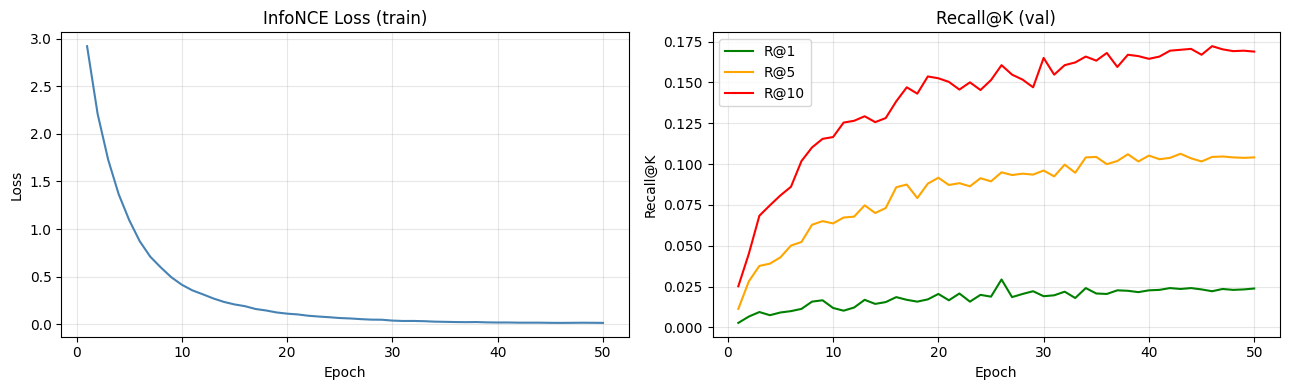

In [20]:
hist_df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(hist_df['epoch'], hist_df['loss'], color='steelblue')
axes[0].set(xlabel='Epoch', ylabel='Loss', title='InfoNCE Loss (train)')
axes[0].grid(alpha=0.3)

for k, c in zip([1, 5, 10], ['green', 'orange', 'red']):
    axes[1].plot(hist_df['epoch'], hist_df[f'R@{k}'], label=f'R@{k}', color=c)
axes[1].set(xlabel='Epoch', ylabel='Recall@K', title='Recall@K (val)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()